In [1]:
import numpy as np
import scipy as sp
from scipy import misc
from matplotlib import pyplot as plt
from scipy.ndimage.interpolation import geometric_transform
%matplotlib inline

In [2]:
im1 = misc.imread("im1.png")
# im2 = misc.imread("im2.png", mode='L')
im2 = sp.ndimage.interpolation.shift(im1, (0, 7))

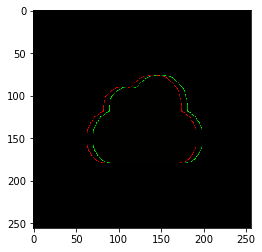

In [3]:
imm = np.zeros((256, 256,3))
imm[:,:,0] = im1
imm[:, :, 1] = im2
plt.imshow(imm)

In [60]:
def FBT(pol, m, x_net, u_net, theta_net):
    f1 = np.exp(-1j*m*theta_net)
    f2 = pol * f1
    fm = np.trapz(f2, theta_net, axis=1)
    fm = fm / (2 * np.pi)
    Fm = np.zeros(x_net.shape, dtype=fm.dtype)
#     flag = m < 0
    ff = sp.special.jn(abs(m), u_net.reshape(-1,1).
                       dot(x_net.reshape(1,-1))) * fm.reshape(-1,1) * u_net.reshape(-1,1)
    Fm = np.trapz(np.real(ff), u_net, axis=0) + 1j*np.trapz(np.imag(ff), u_net, axis=0)
    return Fm

In [14]:
help(sp.special.jn)

Help on ufunc object:

jv = class ufunc(builtins.object)
 |  Functions that operate element by element on whole arrays.
 |  
 |  To see the documentation for a specific ufunc, use np.info().  For
 |  example, np.info(np.sin).  Because ufuncs are written in C
 |  (for speed) and linked into Python with NumPy's ufunc facility,
 |  Python's help() function finds this page whenever help() is called
 |  on a ufunc.
 |  
 |  A detailed explanation of ufuncs can be found in the "ufuncs.rst"
 |  file in the NumPy reference guide.
 |  
 |  Unary ufuncs:
 |  =============
 |  
 |  op(X, out=None)
 |  Apply op to X elementwise
 |  
 |  Parameters
 |  ----------
 |  X : array_like
 |      Input array.
 |  out : array_like
 |      An array to store the output. Must be the same shape as `X`.
 |  
 |  Returns
 |  -------
 |  r : array_like
 |      `r` will have the same shape as `X`; if out is provided, `r`
 |      will be equal to out.
 |  
 |  Binary ufuncs:
 |  ==============
 |  
 |  op(X, Y, out

In [5]:
def polar_trfm(Im, ntheta, nrad, rmax):
    #Polar Transform
    rows, cols = Im.shape
    cx = (rows+1)/2  
    cy = (cols+1)/2
#     rmax=(rows-1)/2
#     deltatheta = 2 * np.pi/(ntheta)
#     deltarad = rmax/(nrad-1)
    theta_int = np.linspace(0, 2*np.pi, ntheta)
    r_int = np.linspace(0, rmax, nrad)
    theta, radius = np.meshgrid(theta_int, r_int)    
    def transform(coords):
        theta = 2.0*np.pi*coords[1] / ntheta
        radius = rmax * coords[0] / nrad
        i = cx + radius*np.cos(theta)
        j = radius*np.sin(theta) + cy
        return i,j
#     xi = radius * np.cos(theta) + cx 
#     yi = radius * np.sin(theta) + cy  
    PolIm = geometric_transform(Im.astype(float), transform, order=1, mode='constant', output_shape=(nrad, ntheta))
    PolIm[np.isnan(PolIm[:])] = 0
    return PolIm

In [10]:
A = 80
p_s = 1
s_ang = np.pi*A/p_s
B = s_ang/2
s_rad = 2*B/np.pi
# ro_max = 7
ro_max = 0.025 * 2*A
k = ro_max/p_s
b = ro_max/2
polim = polar_trfm(im1, int(s_ang), int(s_rad), A)
eps = np.pi/(2*k)
# Imm = np.linspace(-B, B, 5)
bound_m1 = np.floor(2*b*B/A)
bound_h1 = np.floor(2*b*B/(np.pi * A))
bound_mm = np.floor(B)
Im1 = np.arange(-bound_m1, bound_m1)
Ih1 = np.arange(-bound_h1, bound_h1)
Imm = np.arange(-bound_mm, bound_mm)
Tf = np.zeros((len(Im1), len(Ih1), len(Imm)), dtype='complex')

In [13]:
len(Im1)

12

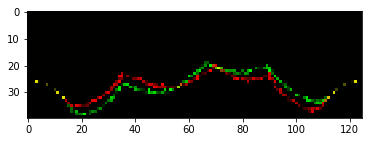

In [63]:
pol1 = polar_trfm(im1, int(s_ang), int(s_rad), A)
pol2 = polar_trfm(im2, int(s_ang), int(s_rad), A)
imm = np.zeros((pol1.shape[0], pol1.shape[1], 3))
imm[:,:,0] = pol1
imm[:, :, 1] = pol2
plt.imshow(imm)

In [64]:
# %%timeit
import scipy
from scipy import integrate
pol1 = polar_trfm(im1, int(s_ang), int(s_rad), A)
pol2 = polar_trfm(im2, int(s_ang), int(s_rad), A)

theta_net = np.linspace(0, 2*np.pi, int(s_ang))
u_net = np.linspace(0, A, int(s_rad))
x_net = np.arange(0, B/A, np.pi/(2*A))
omega_net = np.linspace(0, 2*np.pi, int(s_ang))
psi_net = np.linspace(0, 2*np.pi, int(np.pi*k))
eta_net = np.linspace(0, 2*np.pi, int(k))
# Fm_arr = np.zeros((len(Im1)+len(Ih1)+len(Imm), len(x_net)), dtype='complex')
for it_m1 in range(len(Im1)):
    for it_h1 in range(len(Ih1)):
        for it_mm in range(len(Imm)):
            m1 = Im1[it_m1]
            h1 = Ih1[it_h1]
            mm = Imm[it_mm]
            coef = 2*np.pi * np.exp(1j*(h1+mm)*eps)
            Fm = FBT(pol1, m1+h1+mm, x_net, u_net, theta_net)
#             Fm_arr[it_m1 + it_h1 + it_mm] = Fm
#             Fm = Fm_arr[it_m1 + it_h1 + it_mm]
            Gm = FBT(pol2, mm, x_net, u_net, theta_net)
            func = Fm*np.conj(Gm)*sp.special.jn(m1, b*x_net)*sp.special.jn(h1, b*x_net)
            Tf[it_m1, it_h1, it_mm] = np.trapz(sp.real(func), x_net) + 1j*np.trapz(sp.imag(func), x_net)
            #integrate.quad(lambda x: Fm*np.conj(Gm)*sp.special.jn(m1, b*x)*sp.special(h1, b*x), 0, x_max)
            Tf[it_m1, it_h1, it_mm] = Tf[it_m1, it_h1, it_mm] * coef

In [17]:
B/A/(np.pi*2*A)

20.0

In [65]:
T = np.fft.ifftn(Tf)
# print(T.shape)
[ipsi, ietta, iomegga] = np.unravel_index(np.argmax(T, axis=None), T.shape)
psi = psi_net[ipsi]
etta = eta_net[ietta]
omegga = omega_net[iomegga]
# print(psi, etta, omegga)
alpha = eps + omegga
phi = np.angle(np.exp(1j*psi)*b*(1 + np.exp(1j*(etta - psi + eps))))
rho = np.abs(b * np.sqrt(2*(1 + np.cos(etta - psi + eps))))
x = rho * np.cos(phi)
y = rho * np.sin(phi)
alpha = eps + omegga
print(alpha * 180 / np.pi - 360)
print(x, y)

-7.25806451613
2.03224755112 3.31632659496


In [10]:
import scipy
import os
from scipy import integrate
A = 80
p_s = 1
s_ang = np.pi*A/p_s
B = s_ang/2
s_rad = 2*B/np.pi
ro_max = 7
# ro_max = 0.025 * 2*A
k = ro_max/p_s
b = ro_max/2
list_ang = []
list_translx = []
list_transly = []
listnames = []
path = '/Users/anoshin_alexey/Google Диск/SyntheticData/datasets/model6185/noise_12.2/[0.3 0.01 1] step_5/'
# path = '/Users/anoshin_alexey/Documents/MATLAB/test_sample/new_images/[0.3 0.01 1]/'
im1 = misc.imread(path + 'im_0.tiff',mode="L")
# path = path + '0/'
pol1 = polar_trfm(im1, int(s_ang), int(s_rad), A)
it = 0
for filename in os.listdir(path):
#     if it == 6:
#         break
    if filename.endswith('.tiff') and it != 6:
#         polim = polar_trfm(im1, int(s_ang), int(s_rad), A)
        eps = np.pi/(2*k)
        # Imm = np.linspace(-B, B, 5)
        bound_m1 = np.floor(2*b*B/A)
        bound_h1 = np.floor(2*b*B/(np.pi * A))
        bound_mm = np.floor(B)
        Im1 = np.arange(-bound_m1, bound_m1)
        Ih1 = np.arange(-bound_h1, bound_h1)
        Imm = np.arange(-bound_mm, bound_mm)
        Tf = np.zeros((len(Im1), len(Ih1), len(Imm)), dtype='complex')
        
        im2 = misc.imread(path + filename ,mode="L")
        pol2 = polar_trfm(im2, int(s_ang), int(s_rad), A)
        listnames.append(filename)
        
        theta_net = np.linspace(0, 2*np.pi, int(s_ang))
        u_net = np.linspace(0, A, int(s_rad))
        x_net = np.arange(0, B/A, np.pi/(2*A))
        omega_net = np.linspace(0, 2*np.pi, int(s_ang))
        psi_net = np.linspace(0, 2*np.pi, int(np.pi*k))
        eta_net = np.linspace(0, 2*np.pi, int(k))
        # Fm_arr = np.zeros((len(Im1)+len(Ih1)+len(Imm), len(x_net)), dtype='complex')
        for it_m1 in range(len(Im1)):
            for it_h1 in range(len(Ih1)):
                for it_mm in range(len(Imm)):
                    m1 = Im1[it_m1]
                    h1 = Ih1[it_h1]
                    mm = Imm[it_mm]
                    coef = 2*np.pi * np.exp(1j*(h1+mm)*eps)
                    Fm = FBT(pol1, m1+h1+mm, x_net, u_net, theta_net)
        #             Fm_arr[it_m1 + it_h1 + it_mm] = Fm
        #             Fm = Fm_arr[it_m1 + it_h1 + it_mm]
                    Gm = FBT(pol2, mm, x_net, u_net, theta_net)
                    func = Fm*np.conj(Gm)*sp.special.jn(m1, b*x_net)*sp.special.jn(h1, b*x_net)
                    Tf[it_m1, it_h1, it_mm] = np.trapz(sp.real(func), x_net) + 1j*np.trapz(sp.imag(func), x_net)
                    #integrate.quad(lambda x: Fm*np.conj(Gm)*sp.special.jn(m1, b*x)*sp.special(h1, b*x), 0, x_max)
                    Tf[it_m1, it_h1, it_mm] = Tf[it_m1, it_h1, it_mm] * coef
        T = np.fft.ifftn(Tf)
        # print(T.shape)
        [ipsi, ietta, iomegga] = np.unravel_index(np.argmax(T, axis=None), T.shape)
        psi = psi_net[ipsi]
        etta = eta_net[ietta]
        omegga = omega_net[iomegga]
        # print(psi, etta, omegga)
        alpha = eps + omegga
        phi = np.angle(np.exp(1j*psi)*b*(1 + np.exp(1j*(etta - psi + eps))))
        rho = b * np.sqrt(2*(1 + np.cos(etta - psi + eps)))
        x = rho * np.cos(phi)
        y = rho * np.sin(phi)
        list_ang.append(abs(alpha * 180 / np.pi - 360))
        list_translx.append(x)
        list_transly.append(y)
        it +=1
    if it == 6:
        break

KeyboardInterrupt: 

In [125]:
print(listnames)
print(list_ang)
print(list_translx)

['im_48.tiff', 'im_205.tiff', 'im_194.tiff', 'im_252.tiff']
[152.74285714285713, 152.74285714285713, 152.74285714285713]
[-0.049916369874145779, -0.049916369874145779, -0.049916369874145779]


In [122]:
for i in range(len(list_ang)):
    list_ang[i] = list_ang[i] - 360

In [ ]:
i = 0
it=0
imm = np.zeros((256, 256,3))
imm[:,:,0] = im1
for filename in os.listdir(path):
    it += 1
    print(it)
    if it == 5:
        break
    if filename.endswith(".png") and filename != 'im_0.png':
        im2 = misc.imread(path + filename ,mode="L")
        im = misc.imrotate(im2, -23.142857142857167)
        i += 1
        imm[:,:,1] = im
        misc.imsave('m'+filename, im)
        misc.imsave('colour_'+filename, imm)

In [52]:
T = np.fft.ifftn(Tf)
# print(T.shape)
[ipsi, ietta, iomegga] = np.unravel_index(np.argmax(T, axis=None), T.shape)
psi = psi_net[ipsi]
etta = eta_net[ietta]
omegga = omega_net[iomegga]
# print(psi, etta, omegga)
alpha = eps + omegga
phi = np.angle(np.exp(1j*psi)*b*(1 + np.exp(1j*(etta - psi + eps))))
rho = b * np.sqrt(2*(1 + np.cos(etta - psi + eps)))
x = rho * np.cos(psi+ eps)
y = rho * np.sin(psi + eps)
print(alpha * 180 / np.pi - 360)
print(x, y)

-3.31797235023
0.357986734539 0.79338010139


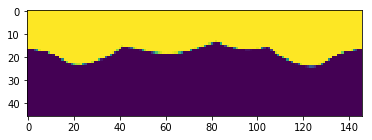

In [30]:
plt.imshow(pol1)

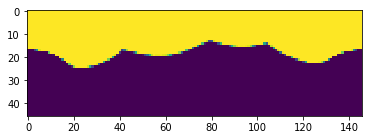

In [31]:
plt.imshow(pol2)

In [208]:
theta_net = np.linspace(0, 2*np.pi, int(s_ang))
u_net = np.linspace(0, A, int(s_rad))
x_net = np.arange(0, B/A, np.pi/(2*A))
omega_net = np.linspace(0, 2*np.pi, int(s_ang))
psi_net = np.linspace(0, 2*np.pi, int(np.pi*k))
eta_net = np.linspace(0, 2*np.pi, int(k))
print(theta_net.shape, u_net.shape, x_net.shape, psi_net.shape, eta_net.shape, omega_net.shape)

(146,) (46,) (47,) (14,) (4,) (146,)


In [109]:
psi_net = np.arange(0, 2*np.pi, np.pi*ro_max/p_s)
eta_net = np.arange(0, 2*np.pi, ro_max/p_s)
omega_net = np.arange(0, 2*np.pi, p_s)
omega_net

array([ 0. ,  1.5,  3. ,  4.5,  6. ])

In [88]:
def polar_transform(Im):
    #Polar Transform
    ntheta = Im.shape[0]
    nrad = Im.shape[1]
    rows, cols = Im.shape
    cx = (cols+1)/2  
    cy = (rows+1)/2
    rmax=(rows-1)/2
#     deltatheta = 2 * np.pi/(ntheta)
#     deltarad = rmax/(nrad-1)
    theta_int = np.linspace(0, 2*np.pi, ntheta)
    r_int = np.linspace(0, rmax, nrad)
    theta, radius = np.meshgrid(theta_int, r_int)    
    def transform(coords):
        theta = 2.0*np.pi*coords[1] / (Im.shape[1] - 1.)
        radius = rmax * coords[0] / Im.shape[0]
        i = cx + radius*np.cos(theta)
        j = radius*np.sin(theta) + cy
        return i,j
#     xi = radius * np.cos(theta) + cx 
#     yi = radius * np.sin(theta) + cy  
    PolIm = geometric_transform(Im.astype(float), transform, order=1,mode='constant')
    PolIm[np.isnan(PolIm[:])] = 0
    return PolIm

In [90]:
import scipy
from scipy import integrate
pol1 = polar_transform(im1)
pol2 = polar_transform(im2)
A = 70
p_s = (np.pi * A)/ 256
B = 128*np.pi
pol = polar_transform(im1)
theta_net = np.arange(0, 2*np.pi, 2*p_s / A)
# print(theta_net.shape)
u_net = np.arange(0, A, A*np.pi/(2*B))
x_net = np.arange(0, B/A, np.pi/(2*A))
for it_m1 in range(len(Im1)):
    for it_h1 in range(len(Ih1)):
        for it_mm in range(len(Imm)):
            m1 = Im1[it_m1]
            h1 = Ih1[it_h1]
            mm = Imm[it_mm]
            coef = 2*np.pi * np.exp(1j*(h1+mm)*eps)
            Fm = FBT(pol1, m1+h1+mm, x_net, u_net, theta_net)
            Gm = FBT(pol2, mm, x_net, u_net, theta_net)
            func = Fm*np.conj(Gm)*sp.special.jn(m1, b*x_net)*sp.special.jn(h1, b*x_net)
            Tf[it_m1, it_h1, it_mm] = np.trapz(sp.real(func), x_net) + 1j*np.trapz(sp.imag(func), x_net)
            #integrate.quad(lambda x: Fm*np.conj(Gm)*sp.special.jn(m1, b*x)*sp.special(h1, b*x), 0, x_max)
            Tf[it_m1, it_h1, it_mm] = Tf[it_m1, it_h1, it_mm] * coef

In [17]:
p_s = 0.5
psi_net = np.arange(0, 2*np.pi, np.pi*ro_max/p_s)
eta_net = np.arange(0, 2*np.pi, ro_max/p_s)
omega_net = np.arange(0, 2*np.pi, p_s)
T = np.fft.ifftn(Tf)
print(T.shape)
[ipsi, ietta, iomegga] = np.unravel_index(np.argmax(T, axis=None), T.shape)
psi = psi_net[ipsi]
etta = eta_net[ietta]
omegga = omega_net[iomegga]
alpha = psi + omegga
rho = b * np.sqrt(2*(1 + np.cos(etta - psi + eps)))
x = rho * np.cos(alpha)
y = rho * np.sin(alpha)
alpha * 180 / np.pi

(6, 2, 146)


IndexError: index 1 is out of bounds for axis 0 with size 1